![](https://seeklogo.com/images/T/tripadvisor-logo-6939149F8F-seeklogo.com.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./data/kaggle_task.csv
./data/main_task.csv
./data/sample_submission.csv


In [60]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [61]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [62]:
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [64]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [66]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [67]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [68]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [69]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* `City`: Город 
* `Cuisine Style`: Кухня
* `Ranking`: Ранг ресторана относительно других ресторанов в этом городе
* `Price Range`: Цены в ресторане в 3 категориях
* `Number of Reviews`: Количество отзывов
* `Reviews`: 2 последних отзыва и даты этих отзывов
* `URL_TA`: страница ресторана на 'www.tripadvisor.com' 
* `ID_TA`: ID ресторана в TripAdvisor
* `Rating`: Рейтинг ресторана

In [71]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
5112,id_5112,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",120.0,$$ - $$$,134.0,"[['Cozy restaurant with a polish atmosphere', ...",/Restaurant_Review-g274856-d4766026-Reviews-Za...,d4766026,0,0.0
23282,id_690,Munich,"['European', 'Vegetarian Friendly']",698.0,$$ - $$$,90.0,"[['Great cocktails', 'Great service and good f...",/Restaurant_Review-g187309-d718256-Reviews-Pac...,d718256,1,4.5
16886,id_722,Hamburg,"['African', 'Bar', 'Barbecue', 'Grill', 'Pub',...",723.0,$$$$,37.0,"[['For MEATlovers', 'Elegant South African din...",/Restaurant_Review-g187331-d10763362-Reviews-H...,d10763362,1,4.0
26899,id_297,Warsaw,"['Polish', 'European', 'Eastern European', 'Ve...",298.0,$$ - $$$,70.0,"[['Generous portions of excellent food', 'Very...",/Restaurant_Review-g274856-d7612224-Reviews-Re...,d7612224,1,4.5
27235,id_1901,Munich,NaN,1917.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187309-d12192162-Reviews-T...,d12192162,1,4.5


In [72]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [73]:
# Для примера я возьму столбец Number of Reviews
def preproc_number_of_reviews(df):
    # Вынесем информацию о наличии пропуска как отдельный признак
    df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
    # Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
    df['Number of Reviews'].fillna(0, inplace=True)
    return df

data = preproc_number_of_reviews(data)

In [74]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [75]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [76]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
def preproc_cities(df):
    df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)
    return df
data = preproc_cities(data)

In [77]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
23970,id_258,['Pub'],259.0,$,42.0,"[['Great little bar!!', 'Great little bar'], [...",/Restaurant_Review-g274772-d10325681-Reviews-K...,d10325681,1,5.0,...,0,0,0,0,0,0,0,0,0,0
13654,id_13922,"['Brew Pub', 'Fast Food', 'Wine Bar']",13925.0,NaN,0.0,"[[], []]",/Restaurant_Review-g187147-d7811215-Reviews-Ca...,d7811215,1,1.0,...,0,0,1,0,0,0,0,0,0,0
49637,id_6263,"['French', 'Contemporary']",6264.0,$$ - $$$,64.0,"[['Absolutely fabulous !!!'], ['08/30/2016']]",/Restaurant_Review-g187147-d10592291-Reviews-L...,d10592291,1,4.0,...,0,0,1,0,0,0,0,0,0,0
31010,id_1807,['Fast Food'],1812.0,NaN,5.0,"[['perfect', 'Best frites in Amsterdam'], ['08...",/Restaurant_Review-g188590-d10628031-Reviews-P...,d10628031,1,5.0,...,0,0,0,0,0,0,0,0,0,0
49100,id_1845,NaN,1860.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187309-d10031271-Reviews-E...,d10031271,1,4.5,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [78]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [79]:
def preproc_price_range(df):
    # Заменим категориальный признак числами
    df['Price Range'].replace(to_replace={ '$': 1, '$$ - $$$': 2, '$$$$': 3}, inplace=True)
    # Сохраним данные о записях, где не был указан уровень цен.
    df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
    # Заполним пропуски, пока что воспользуемся просто медианой.
    df['Price Range'].fillna(df['Price Range'].median(), inplace=True)
    return df

data = preproc_price_range(data)

In [80]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_isNAN
37758,id_7237,['Mediterranean'],7238.0,2.0,25.0,"[['Awful Service, food good', '€1.05 croquette...",/Restaurant_Review-g187497-d2056531-Reviews-Bo...,d2056531,1,3.0,...,0,0,0,0,0,0,0,0,0,0
26753,id_2485,"['French', 'Cafe', 'European', 'Vegetarian Fri...",2490.0,2.0,201.0,"[['Great entertainment', 'Retirement lunch'], ...",/Restaurant_Review-g186338-d2006492-Reviews-Ca...,d2006492,1,4.0,...,0,0,0,0,0,0,0,0,0,0
45877,id_1361,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",1363.0,2.0,311.0,"[['Variado y a un precio razonable', 'Good foo...",/Restaurant_Review-g187514-d3136131-Reviews-Re...,d3136131,1,4.0,...,0,0,0,0,0,0,0,0,0,0
7922,id_7922,"['Bar', 'Cafe', 'Spanish', 'Pub']",6345.0,2.0,2.0,"[[], []]",/Restaurant_Review-g187514-d12122808-Reviews-3...,d12122808,0,0.0,...,0,0,0,0,0,0,0,0,0,1
14664,id_909,"['Japanese', 'Sushi', 'Asian', 'Fast Food']",910.0,2.0,36.0,"[['Ok sushi, but used to be better', 'Nice sus...",/Restaurant_Review-g190479-d4366934-Reviews-Wa...,d4366934,1,4.0,...,1,0,0,0,0,0,0,0,0,0


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

#### Возьмем следующий признак "Cuisine Style".

Для начала добавим к записям признак с колличеством представленых типов кухонь. Если в данных отсутствует информация о типах кухонь, то считаем, что в этом ресторане предлагается только один тип кухни. Так же пометим записи, где не укзан тип кухни.

In [81]:
def string_to_list(s):
    return s[1:-1].replace("'", "").split(', ')

def count_styles(s):
    return len(string_to_list(s)) if s is not np.nan else 1

def get_cuisines_list(df):
    cuisines = set()
    for cuisine in df['Cuisine Style'].dropna().values:
        cuisines.update(string_to_list(cuisine))
    return cuisines

def update_cuisines_rating(cuisine_styles, cuisines_ratings):
        for style in cuisine_styles:
            cuisines_ratings[style] = cuisines_ratings[style] + 1

def calc_cuisines_ratings(df, cuisines):
    cuisines_ratings = {}
    for cuisine in cuisines:
        cuisines_ratings[cuisine] = 0
    
    for cuisine in df['Cuisine Style'].dropna().values:
        update_cuisines_rating(string_to_list(cuisine), cuisines_ratings)
    
    return cuisines_ratings

def preproc_cuisine_style(df):
    # добавим к записям признак с колличеством представленых типов кухонь
    df['Cuisine Style Count'] = df['Cuisine Style'].apply(count_styles)
    # пометим записи, где не укзан тип кухни.
    df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')

    # отдельными признаками добавим типы кухни, которые представлены хотя бы в 1% ресторанов.
    # соберем список всех кухонь представленых в датасете.
    cuisines_list = get_cuisines_list(df)

    # соберем данные о том, в скольки ресторанах представлена каждая кухня.
    cuisines_rating = calc_cuisines_ratings(df, cuisines_list)

    # выделим две группы кухонь те которые представлены хотя бы в 1% ресторанов и остальные
    top_cuisines = []
    low_cuisines = []
    for cuisine in cuisines_rating:
        if cuisines_rating[cuisine] > len(data) * .01:
            top_cuisines.append(cuisine)
        else:
            low_cuisines.append(cuisine)

    # создадим отдельные признаки для кухонь представленых хотя бы в 1%
    def top_cuisine_present(x):
        if pd.isna(x): 
            return 0
        return 1 if cuisine in x else 0

    for cuisine in top_cuisines:
        dummy = df['Cuisine Style'].apply(top_cuisine_present)
        df['Cuisine_' + cuisine] = dummy

    # для остальных добавим признак Cuisine_Other
    def is_low_cuisine_present(x):
        if pd.isna(x): 
            return 0
        for cuisine in low_cuisines:
            if cuisine in x:
                return 1
        return 0

    df['Cuisine_Other'] = df['Cuisine Style'].apply(is_low_cuisine_present)
    
    return df

data = preproc_cuisine_style(data)

In [82]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cuisine_Barbecue,Cuisine_Mediterranean,Cuisine_Halal,Cuisine_Eastern European,Cuisine_Chinese,Cuisine_Central European,Cuisine_Cafe,Cuisine_Gastropub,Cuisine_Healthy,Cuisine_Other
32597,id_2229,"['Italian', 'French', 'Pub', 'Gastropub', 'Veg...",2230.0,2.0,18.0,"[['A hidden gem'], ['11/17/2017']]",/Restaurant_Review-g187147-d12929348-Reviews-A...,d12929348,1,5.0,...,0,0,0,0,0,0,0,1,0,0
25797,id_2748,"['International', 'European', 'Czech']",2754.0,2.0,6.0,"[[], []]",/Restaurant_Review-g274707-d5426852-Reviews-Ko...,d5426852,1,4.0,...,0,0,0,0,0,0,0,0,0,0
3041,id_3041,"['Mediterranean', 'Spanish']",2479.0,1.0,44.0,"[['Very good creative ""tapas""', 'Splendid. In ...",/Restaurant_Review-g187514-d9866908-Reviews-La...,d9866908,0,0.0,...,0,1,0,0,0,0,0,0,0,0
47940,id_6266,['Barbecue'],6267.0,2.0,5.0,"[[], []]",/Restaurant_Review-g187497-d4042488-Reviews-Re...,d4042488,1,3.5,...,1,0,0,0,0,0,0,0,0,0
13350,id_97,"['Peruvian', 'Seafood', 'South American', 'Veg...",98.0,2.0,323.0,"[['Super ceviche with warm staff!', 'Amazing f...",/Restaurant_Review-g187147-d9767590-Reviews-Ma...,d9767590,1,4.5,...,0,0,0,0,0,0,0,0,0,1


#### Возьмем следующий признак "Reviews".

Добавим признаки с датами последнего и предпоследнего отзывов, а также колличество дней между ними.

In [83]:
def get_dates_list(x):
    dates = x.split('], [')[1]
    dates = dates[:-2]
    dates = dates.replace("'", "")
    return dates.split(', ')

def get_penultimate_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[-1]) if len(dates) >= 1 else np.NaN

def get_last_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[0]) if len(dates) >= 1 else np.NaN

def preproc_reviews(df):
    # заполним пропуски пустыми значениями
    df['Reviews'].fillna('[[], []]', inplace=True)

    # отметим записи коментарии в которых отсутствуют
    df['Reviews_NA'] = (df['Reviews'] == '[[], []]').astype(int)

    # создадим признаки с датами двух последних коментариев
    df['Penultimate_Review'] = df['Reviews'].apply(lambda x: get_penultimate_review(x))
    df['Last_Review'] = df['Reviews'].apply(lambda x: get_last_review(x))

    # создадим признак количеством дней прошедшими между двумя последними коментариями
    df = df.assign(Review_Time_Delta = lambda x: (x['Last_Review'] - x['Penultimate_Review']).dt.days)

    # звполним пустые записи
    df['Review_Time_Delta'] = df['Review_Time_Delta'].fillna(0)
    return df

data = preproc_reviews(data)

In [84]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cuisine_Chinese,Cuisine_Central European,Cuisine_Cafe,Cuisine_Gastropub,Cuisine_Healthy,Cuisine_Other,Reviews_NA,Penultimate_Review,Last_Review,Review_Time_Delta
42891,id_50,"['Mexican', 'Latin', 'Fast Food', 'Central Ame...",51.0,1.0,386.0,"[['Nice tacos', 'Excellent food and location']...",/Restaurant_Review-g189852-d2174368-Reviews-La...,d2174368,1,4.0,...,0,0,0,0,0,1,0,2017-12-10,2017-12-29,19.0
34753,id_3219,"['American', 'Fast Food']",3223.0,1.0,86.0,"[['Busiest McDonalds EVER', 'Fine Visit'], ['1...",/Restaurant_Review-g189158-d5959945-Reviews-Mc...,d5959945,1,3.5,...,0,0,0,0,0,0,0,2017-11-11,2017-12-16,35.0
32714,id_223,"['American', 'Bar', 'Vegetarian Friendly', 'Ve...",225.0,2.0,95.0,"[['Nice burger place', 'Great burger gig in to...",/Restaurant_Review-g187309-d10497900-Reviews-H...,d10497900,1,4.0,...,0,0,0,0,0,0,0,2017-08-10,2017-09-28,49.0
40558,id_888,"['Japanese', 'Sushi', 'Asian', 'Healthy', 'Veg...",889.0,2.0,254.0,"[['A tasty Japanese feast', ""It's real Japanes...",/Restaurant_Review-g187323-d2718037-Reviews-Ha...,d2718037,1,4.0,...,0,0,0,0,1,0,0,2017-07-28,2017-10-16,80.0
1520,id_1520,NaN,2589.0,2.0,2.0,"[['place to visit onces'], ['02/19/2017']]",/Restaurant_Review-g189158-d12163473-Reviews-M...,d12163473,0,0.0,...,0,0,0,0,0,0,0,2017-02-19,2017-02-19,0.0


Попробуем по тексту двух последних коментариев понять были ли они положительными либо отрицательными.

In [85]:
data['Reviews'].sample(5)

47428    [['Delicious Food,an authentic Greek Taverna',...
25567    [['Amazing good pizza and super service', 'Qui...
611      [['Cute little spot for breakfast', 'Swing whi...
37447    [['Friendly and good pizzeria', 'Average Meal'...
23200                                             [[], []]
Name: Reviews, dtype: object

In [86]:
chars_to_replace = "',.!?&-+/\""

def get_reviews_words(x):
    reviews = x.split('], [')[0]
    reviews = reviews[2:]
    reviews = reviews.split("', '")
    if len(reviews) == 1:
        return []

    words = set()
    for review in reviews:
        for ch in chars_to_replace:
            review = review.replace(ch, '')
        review = review.lower()
    return words

def count_review_words(x):
    words = get_reviews_words(x)

# для начала соберем список слов которые есть в коментариях.
# data['Reviews'].sample(10).apply(count_review_words)
# в процессе выяснилось, что подавляющее большинство коментариев положительные, пока отложим это

### Это "жжж" неспроста

В датасете у нас есть ссылка страничку ресторана в системе TripAdrisor. Рассмотрим несколько страниц и попробуем выделить потенциально полезную нам информацию.

Опишем необходимые для парсинга функции

In [87]:
# from lxml import html
# from bs4 import BeautifulSoup

# def parse_ratings_and_reviews(node):
#     result = ''
#     rating_block = node.find('div').findAll('div', recursive=False)[2]
#     rating_block = rating_block.findAll('div', recursive=False)
#     if len(rating_block) < 2:
#         return result

#     ratings = rating_block[1].findAll('div')
#     for rating in ratings:
#         spans = rating.findAll('span', recursive=False)
#         title = spans[1].text.lower()
#         value = spans[2].find('span').attrs['class'][1].split('_')[1]
#         result += '{}:{};'.format(title, value)
#     return result

# def parse_location_and_contact(node):
#     location_block = node.find('div').find('div')
#     location_block = location_block.findAll('div', recursive=False)[1]
#     distance_el = location_block.find('b')
#     if distance_el is None:
#         return np.NaN
#     return float(distance_el.text.split()[0])

# def parse_details_block(node):
#     if node is None:
#         return details_str.format('','',)

#     is_verified = node.find('span', {'class': 'ui_icon verified-checkmark'}) is not None
#     has_phone_number = node.find('a', string='+ Add phone number') is None
#     has_hours = node.find('a', string='+ Add hours') is None
#     has_website = node.find('a', string='+ Add website') is None
#     has_menu = node.find('a', string='Menu') is not None
        
#     return {} if  else { 
        
#     }

# def parse_page_data(html):
#     soup = BeautifulSoup(html)
#     overview_tabs = soup.find('div', {'data-tab': 'TABS_OVERVIEW'})
#     if overview_tabs is None:
#         return {}
#     overview_columns = overview_tabs.findAll('div', {'class':'ui_column'})
#     ratings = parse_ratings_and_reviews(overview_columns[0])
#     # parse_details(overview_columns[1])
#     distance = parse_location_and_contact(overview_columns[2])
#     # details = parse_details_block(soup.find('div', {'data-test-target':'restaurant-detail-info'}))
#     details = ''
#     has_tcAward = soup.find('img', {'class': 'tcAward'}) is not None,
#     return '{},{},{},{}'.format(distance, ratings, details, has_tcAward)

In [88]:
# import requests
# from multiprocessing import Pool

# TRIP_ADVISOR_URL_TEMPLATE = 'https://www.tripadvisor.com{}'
# PAGE_PATH_TEMPLATE = './pages/{}.html'

# def get_id_from_url(url):
#     return url.split('-')[2]

# def parse_page(url):
#     id = get_id_from_url(url)
#     r = requests.get(TRIP_ADVISOR_URL_TEMPLATE.format(url))
#     return '{},{}'.format(id, parse_page_data(r.text))

# p = Pool(2)
# p.map(parse_page, list(data['URL_TA'][:10]))

# data['URL_TA'][123:133].apply(grab_page)

# for dirname, _, filenames in os.walk('./pages'):
#     print('Скачано {} страниц.'.format(len(filenames)))


Посмотрим, какую информацию мы сможем из них извлечь.

Удалим все признаки, не являющиесь числовыми.

In [89]:
object_cols = list(data.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
data = data.drop(labels=object_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   sample                       50000 non-null  int64  
 4   Rating                       50000 non-null  float64
 5   Number_of_Reviews_isNAN      50000 non-null  uint8  
 6   City_Amsterdam               50000 non-null  uint8  
 7   City_Athens                  50000 non-null  uint8  
 8   City_Barcelona               50000 non-null  uint8  
 9   City_Berlin                  50000 non-null  uint8  
 10  City_Bratislava              50000 non-null  uint8  
 11  City_Brussels                50000 non-null  uint8  
 12  City_Budapest                50000 non-null  uint8  
 13  City_Copenhagen 

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   sample                       50000 non-null  int64  
 4   Rating                       50000 non-null  float64
 5   Number_of_Reviews_isNAN      50000 non-null  uint8  
 6   City_Amsterdam               50000 non-null  uint8  
 7   City_Athens                  50000 non-null  uint8  
 8   City_Barcelona               50000 non-null  uint8  
 9   City_Berlin                  50000 non-null  uint8  
 10  City_Bratislava              50000 non-null  uint8  
 11  City_Brussels                50000 non-null  uint8  
 12  City_Budapest                50000 non-null  uint8  
 13  City_Copenhagen 

Взглянем на оставшиесь признакми в поисках выбросов.



### Посмотрим распределение признака

0.011005511144993175

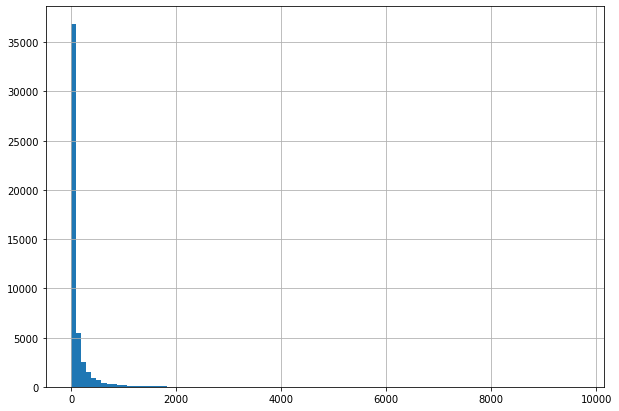

In [105]:
#### Review_Time_Delta
data['Review_Time_Delta'].hist(bins=100)


data['Review_Time_Delta'].corr(data['Rating'])


#### Review_Time_Delta

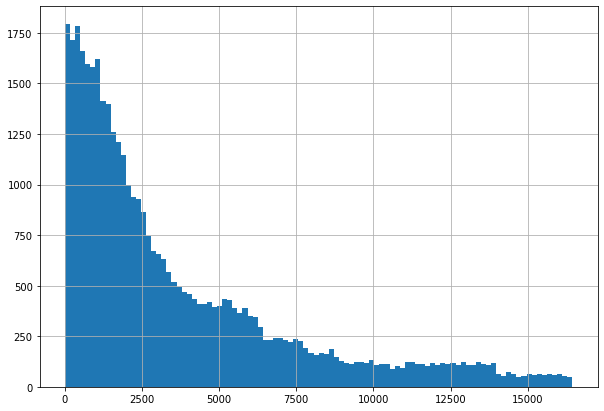

In [101]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

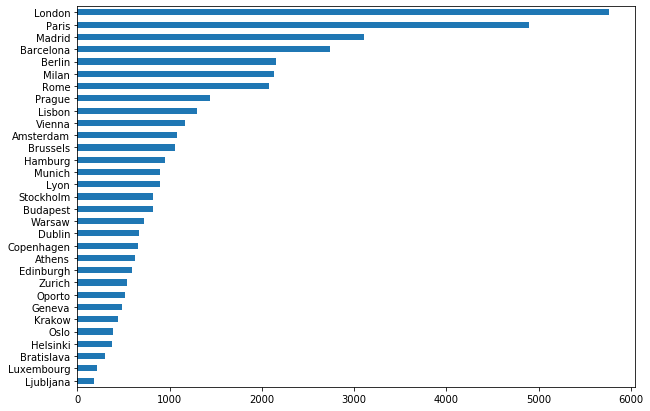

In [91]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

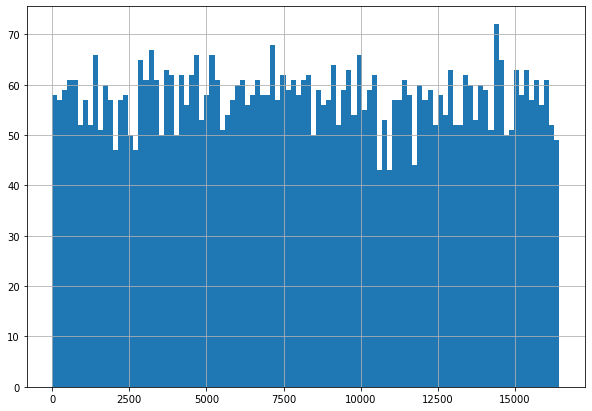

In [294]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

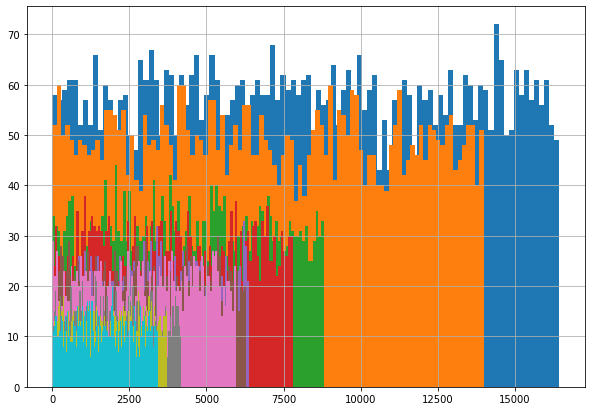

In [295]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

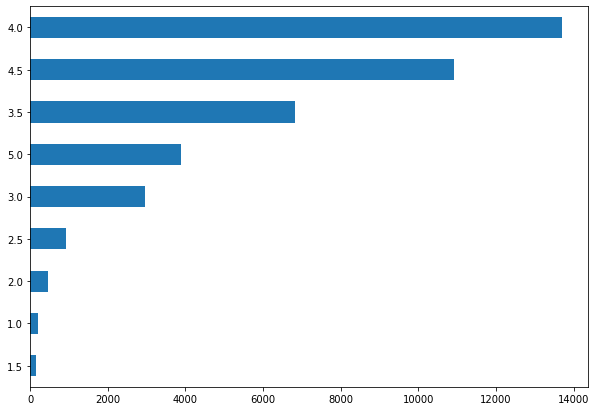

In [296]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

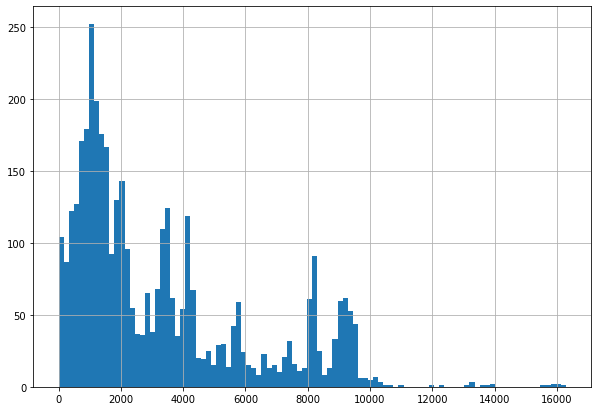

In [297]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

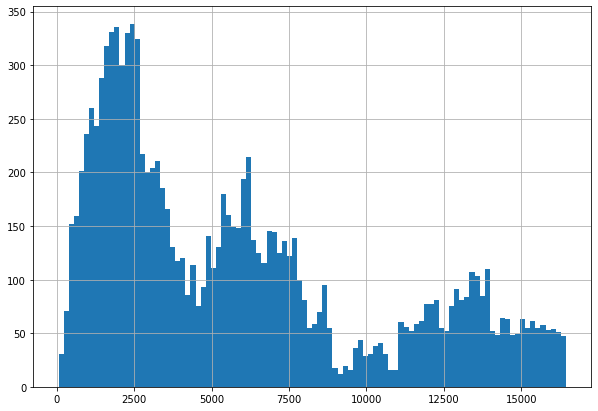

In [298]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

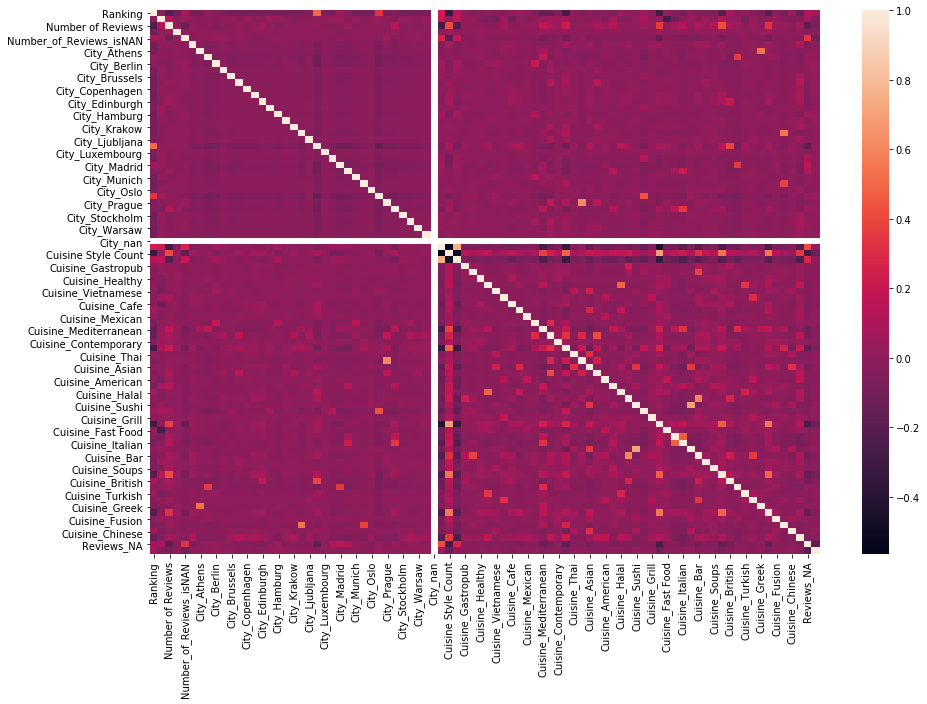

In [299]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [300]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [301]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд... 
    df_output = preproc_number_of_reviews(df_output)
    # тут ваш код по обработке NAN    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = preproc_cities(df_output)
    # тут ваш код не Encoding фитчей
    
    df_output = preproc_price_range(df_output)

    df_output = preproc_cuisine_style(df_output)

    df_output = preproc_reviews(df_output)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    # object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    # df_output.drop(object_columns, axis = 1, inplace=True)

    object_cols = list(df_output.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
    df_output = df_output.drop(labels=object_cols, axis=1)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [302]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Cuisine_Turkish,Cuisine_Barbecue,Cuisine_Greek,Cuisine_Vegan Options,Cuisine_Fusion,Cuisine_Portuguese,Cuisine_Chinese,Cuisine_Other,Reviews_NA,Review_Time_Delta
44885,9016.0,2.0,6.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,464.0
4673,2279.0,2.0,3.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
17392,1932.0,2.0,102.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,86.0
40365,3726.0,2.0,0.0,1,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
28025,1084.0,2.0,24.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,273.0
39372,9596.0,2.0,61.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,128.0
40371,5046.0,2.0,856.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14.0
47954,5085.0,2.0,0.0,1,4.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0.0
5219,959.0,2.0,5.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39.0
44561,277.0,2.0,51.0,1,4.5,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,40.0


In [303]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   sample                       50000 non-null  int64  
 4   Rating                       50000 non-null  float64
 5   Number_of_Reviews_isNAN      50000 non-null  uint8  
 6   City_Amsterdam               50000 non-null  uint8  
 7   City_Athens                  50000 non-null  uint8  
 8   City_Barcelona               50000 non-null  uint8  
 9   City_Berlin                  50000 non-null  uint8  
 10  City_Bratislava              50000 non-null  uint8  
 11  City_Brussels                50000 non-null  uint8  
 12  City_Budapest                50000 non-null  uint8  
 13  City_Copenhagen 

In [304]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [305]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [306]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 86), (40000, 86), (40000, 85), (32000, 85), (8000, 85))

# Model 
Сам ML

In [307]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [308]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [309]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [310]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209200625


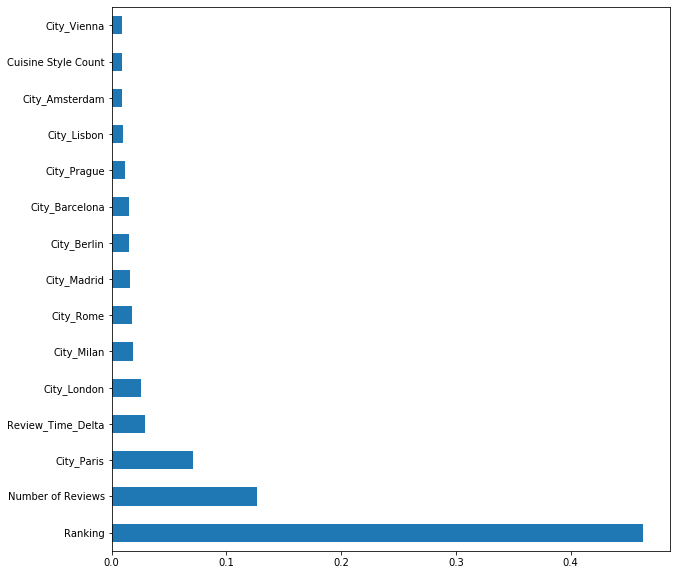

In [311]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [312]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Cuisine_Turkish,Cuisine_Barbecue,Cuisine_Greek,Cuisine_Vegan Options,Cuisine_Fusion,Cuisine_Portuguese,Cuisine_Chinese,Cuisine_Other,Reviews_NA,Review_Time_Delta
2650,774.0,2.0,142.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,130.0
167,4310.0,2.0,13.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.0
788,1635.0,2.0,11.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,280.0
7345,4101.0,2.0,102.0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,118.0
854,6091.0,2.0,17.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5092,1439.0,2.0,9.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,515.0
7503,2065.0,2.0,31.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
1810,2076.0,2.0,3.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
5989,6235.0,2.0,6.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
9348,1516.0,2.0,11.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,497.0


In [313]:
test_data = test_data.drop(['Rating'], axis=1)

In [314]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [315]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [316]:
predict_submission

array([3.01 , 4.325, 4.445, ..., 3.01 , 4.495, 4.275])

In [248]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.325
2,id_2,4.445
3,id_3,4.385
4,id_4,4.490
5,id_5,4.460
6,id_6,2.450
7,id_7,2.735
8,id_8,4.085
9,id_9,4.690


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
